# H2O.ai

In [875]:
import sys
lib_dir = "../../libs/"
if lib_dir not in sys.path:
    sys.path.append(lib_dir)

In [876]:
import automl

import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.automl import H2OAutoML
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

plt.style.use('fivethirtyeight')

In [877]:
#h2o.cluster().shutdown()

In [878]:
h2o.init(min_mem_size=6)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,4 hours 23 mins
H2O cluster timezone:,Europe/Amsterdam
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.2
H2O cluster version age:,4 months and 6 days !!!
H2O cluster name:,H2O_from_python_rafael_j9vh10
H2O cluster total nodes:,1
H2O cluster free memory:,5.640 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [879]:
df = pd.read_pickle('../../data/Visual_well_being/merged_features.pickle')

In [880]:
df.head()

,age,user_followed_by,user_follows,user_posted_photos,Person,Plant,Food,Collage,Outdoors,Book,...,employed,income,participate,P,E,R,M,A,PERMA,imagecount
0,42.0,364.0,814.0,2037.0,0.220913,0.034855,0.013746,0.025037,0.021600,0.010309,...,0,5,1,3.000000,5.333333,3.666667,5.333333,5.333333,4.4375,1515.0
1,36.0,198.0,288.0,124.0,0.306452,0.008065,0.056452,0.008065,0.008065,0.000000,...,2,6,1,7.666667,8.333333,7.333333,7.666667,8.000000,7.8750,123.0
2,21.0,311.0,240.0,350.0,0.482857,0.005714,0.037143,0.057143,0.000000,0.011429,...,3,1,1,4.666667,8.000000,6.333333,4.666667,5.000000,5.6875,350.0
3,37.0,732.0,943.0,610.0,0.191803,0.011475,0.011475,0.011475,0.011475,0.001639,...,6,1,1,10.000000,9.333333,10.000000,9.333333,7.666667,9.2500,609.0
4,29.0,24.0,65.0,64.0,0.281250,0.125000,0.000000,0.015625,0.015625,0.031250,...,2,2,1,6.333333,4.666667,8.333333,5.666667,8.333333,6.6250,64.0


In [881]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 0 to 158
Data columns (total 90 columns):
age                                           159 non-null float64
user_followed_by                              159 non-null float64
user_follows                                  159 non-null float64
user_posted_photos                            159 non-null float64
Person                                        159 non-null float64
Plant                                         159 non-null float64
Food                                          159 non-null float64
Collage                                       159 non-null float64
Outdoors                                      159 non-null float64
Book                                          159 non-null float64
Sky                                           159 non-null float64
Alcohol                                       159 non-null float64
Crowd                                         159 non-null float64
Toy                     

## Correlated Columns

In [839]:
def drop_correlated_columns(df, threshold, target):

    aux = df.copy().drop(target, axis=1)
    result = df.copy()
    
    # Create correlation matrix
    corr_matrix = aux.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Drop features 
    
    to_drop = [column for column in to_drop if column not in target_features]
    
    print(to_drop)
    
    result.drop(to_drop, axis=1)
    
    return result

In [874]:
target_features = ['P', 'E', 'R', 'M', 'A', 'PERMA']

# Get correlated columns

df = drop_correlated_columns(df, 0.8, target_features)

['Dusk', 'Sunrise', 'Sunset', 'Swimwear', 'City', 'Club', 'avg_number_of_faces_over_images_with_faces', 'avg_number_of_faces_over_all_images', 'avg_posts_day', 'avg_posts_night', 'avg_posts_whole_date', 'HAPPY', 'born', 'imagecount']


In [841]:
df.shape

(159, 102)

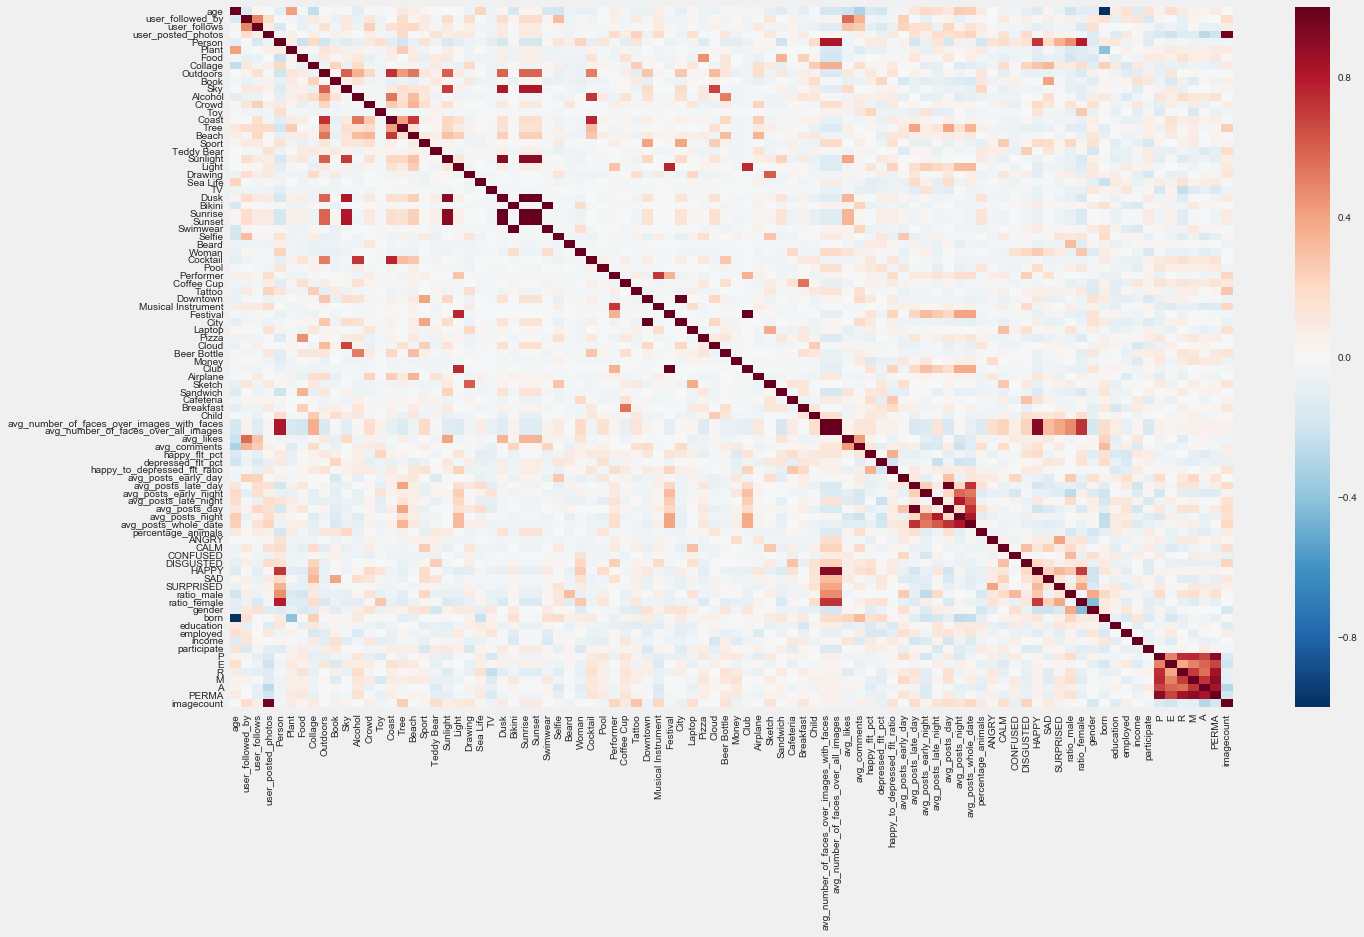

In [882]:
plt.figure(figsize=(20,12))

sns.heatmap(df.corr())

## Sparse Features

In [883]:
threshold = 0.7

columns = df.columns

for column in columns:
    
    percentage_of_zeros = len(df[df[column] == 0])/len(df)
    
    if (percentage_of_zeros > threshold):
        
        df = df.drop(column, axis=1)

In [884]:
df.shape

(159, 48)

## Basic Cleaning

In [885]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,159.0,30.842767,9.241167,19.000000,24.000000,29.000000,35.000000,68.000000
user_followed_by,159.0,389.106918,627.111033,0.000000,70.000000,191.000000,391.500000,4240.000000
user_follows,159.0,552.352201,1130.472020,0.000000,86.500000,210.000000,475.000000,7322.000000
user_posted_photos,159.0,278.371069,435.241073,1.000000,22.000000,100.000000,374.000000,2997.000000
Person,159.0,0.413538,0.279651,0.000000,0.189652,0.387755,0.622543,1.000000
Plant,159.0,0.038498,0.090086,0.000000,0.000000,0.020833,0.045163,1.000000
Food,159.0,0.023865,0.054885,0.000000,0.000000,0.007605,0.022604,0.500000
Collage,159.0,0.016142,0.025396,0.000000,0.000000,0.007463,0.022739,0.161905
Outdoors,159.0,0.012003,0.020507,0.000000,0.000000,0.002112,0.014418,0.130435
Book,159.0,0.004325,0.008827,0.000000,0.000000,0.000000,0.005402,0.062500


### Object Tags

### Useless Columns

## Removing Outliers

In [887]:
columns = df.select_dtypes(include=[np.number]).columns

for column in columns:
    
    if (df[(df[column] >= df[column].quantile(0.05)) & (df[column] <= df[column].quantile(0.95))].shape[1] < df.shape[1]*.6):
        df = df.drop(column, axis=1)

In [888]:
df.shape

(159, 48)

In [909]:
h2o.remove_all()

for feature in target_features[0]:
    
    print('### Runnning AutoML for Predicting {} ###'.format(feature))
    
    aux_target_features = target_features.copy()
    
    #Remove remaining features as they could leak info into our dataset
    
    aux_target_features.remove(feature)
    
    df_pred = df.drop(aux_target_features, axis=1)
    
    ### Teste ###
    
    #df_pred = df_pred.iloc[:,:60]
    
    df_train = df_pred.sample(frac=0.8)
    
    h2o_train = h2o.H2OFrame(df_train)
    h2o_test = h2o.H2OFrame(df_pred[~np.isin(df_pred.index, df_train.index)])
    
    exclude_algos = ['DeepLearning', 'StackedEnsemble', 'GLM']
    
    automl.generate_predictions_automl(h2o_train, h2o_test, exclude_algos, 10, 123, 15, feature)

### Runnning AutoML for Predicting P ###


/anaconda/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
['age', 'user_followed_by', 'user_follows', 'user_posted_photos', 'Person', 'Plant', 'Food', 'Collage', 'Outdoors', 'Book', 'Sky', 'Alcohol', 'Crowd', 'Toy', 'Coast', 'avg_number_of_faces_over_images_with_faces', 'avg_number_of_faces_over_all_images', 'avg_likes', 'avg_comments', 'happy_flt_pct', 'depressed_flt_pct', 'happy_to_depressed_flt_ratio', 'avg_posts_early_day', 'avg_posts_late_day', 'avg_posts_early_night', 'avg_posts_late_night', 'avg_posts_day', 'avg_posts_night', 'avg_posts_whole_date', 'percentage_animals', 'HAPPY', 'SAD', 'SURPRISED', 'ratio_male', 'ratio_female', 'gender', 'born', 'education', 'employed', 'income', 'participate', 'P', 'imagecount']
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid_0_AutoML_20181021_195733_model_7,3.01959,1.7377,3.01959,1.40351,0.259889
GBM_grid_0_AutoML_20181021_195733_model_8,3.05777,1.74865,3.05777,1.41295,0.260749
GBM_grid_0_AutoML_20181021_195733_model_6,3.06227,1.74993,3.06227,1.41409,0.26082
GBM_grid_0_AutoML_20181021_195733_model_0,3.22725,1.79645,3.22725,1.38495,0.268064
GBM_grid_0_AutoML_20181021_195733_model_4,3.23654,1.79904,3.23654,1.4847,0.262983
XRT_0_AutoML_20181021_195733,3.23947,1.79985,3.23947,1.39884,0.269919
GBM_grid_0_AutoML_20181021_195733_model_5,3.42682,1.85117,3.42682,1.47062,0.276085
DRF_0_AutoML_20181021_195733,3.42713,1.85125,3.42713,1.45159,0.274798
GBM_grid_0_AutoML_20181021_195733_model_1,3.60515,1.89872,3.60515,1.5583,0.279699
GBM_grid_0_AutoML_20181021_195733_model_3,3.60515,1.89872,3.60515,1.5583,0.279699



                                      variable  relative_importance  \
0                          avg_posts_early_day          1095.923096   
1                        avg_posts_early_night           416.178528   
2                                 avg_comments           231.532730   
3                         avg_posts_late_night           190.414352   
4                                         Food           176.688065   
5                                   ratio_male           172.858826   
6                                    avg_likes           146.708191   
7                         avg_posts_whole_date           128.428299   
8                                 user_follows           127.550995   
9                                 ratio_female           121.923561   
10                                        Book           120.820786   
11                           depressed_flt_pct           117.274689   
12                happy_to_depressed_flt_ratio           117.202805   
13   

In [910]:
df.loc[:,target_features].describe()

,P,E,R,M,A,PERMA
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,6.670860,7.094340,7.088050,6.911950,6.930818,6.930922
std,1.690125,1.447697,1.913184,1.846597,1.542677,1.424069
min,1.666667,2.666667,1.000000,2.000000,2.333333,3.250000
25%,5.666667,6.333333,6.000000,6.000000,6.000000,6.093750
50%,6.666667,7.000000,7.000000,7.000000,7.000000,7.125000
75%,8.000000,8.333333,8.333333,8.166667,8.000000,7.750000
max,10.000000,9.666667,10.000000,10.000000,10.000000,9.562500


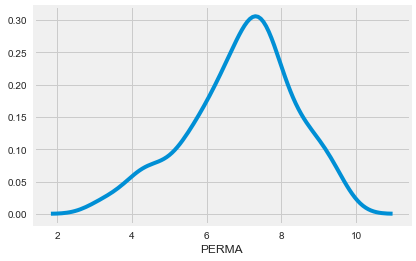

In [911]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

sns.distplot(df.PERMA, hist=False)

/anaconda/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


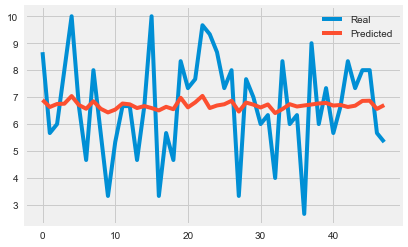

In [912]:
model = h2o.get_model('GBM_grid_0_AutoML_20181021_195733_model_7')

# See how a P model performed

df_test = df.sample(frac=0.3)

h2o_validate = h2o.H2OFrame(df_test.drop(target_features, axis=1))

pred = model.predict(h2o_validate)

plt.plot(range(0,len(df_test)), df_test.P, label='Real')
plt.plot(range(0,len(pred.as_data_frame())), pred.as_data_frame().predict, label='Predicted')

plt.legend()

In [913]:
df_importances = model._model_json['output']['variable_importances'].as_data_frame()

df_importances

,variable,relative_importance,scaled_importance,percentage
0,avg_posts_early_day,1095.923096,1.000000,0.219288
1,avg_posts_early_night,416.178528,0.379752,0.083275
2,avg_comments,231.532730,0.211267,0.046328
3,avg_posts_late_night,190.414352,0.173748,0.038101
4,Food,176.688065,0.161223,0.035354
5,ratio_male,172.858826,0.157729,0.034588
6,avg_likes,146.708191,0.133867,0.029356
7,avg_posts_whole_date,128.428299,0.117187,0.025698
8,user_follows,127.550995,0.116387,0.025522
9,ratio_female,121.923561,0.111252,0.024396


In [914]:
df_importances.scaled_importance.describe()

count    42.000000
mean      0.108576
std       0.154503
min       0.010587
25%       0.047678
50%       0.072439
75%       0.109437
max       1.000000
Name: scaled_importance, dtype: float64

In [915]:
low_importances = df_importances[df_importances.scaled_importance < 0.07]
df_reloaded = df.drop(low_importances.variable, axis=1)

In [916]:
h2o.remove_all()

for feature in target_features[0]:
    
    print('### Runnning AutoML for Predicting {} ###'.format(feature))
    
    aux_target_features = target_features.copy()
    
    #Remove remaining features as they could leak info into our dataset
    
    aux_target_features.remove(feature)
    
    df_pred = df_reloaded.drop(aux_target_features, axis=1)
    
    ### Teste ###
    
    #df_pred = df_pred.iloc[:,:60]
    
    df_train = df_pred.sample(frac=0.8)
    
    h2o_train = h2o.H2OFrame(df_train)
    h2o_test = h2o.H2OFrame(df_pred[~np.isin(df_pred.index, df_train.index)])
    
    exclude_algos = ['DeepLearning', 'GLM', 'StackedEnsemble']
    
    automl.generate_predictions_automl(h2o_train, h2o_test, exclude_algos, 10, 123, 15, feature)

### Runnning AutoML for Predicting P ###


/anaconda/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
['age', 'user_followed_by', 'user_follows', 'Person', 'Food', 'Book', 'Sky', 'Crowd', 'avg_likes', 'avg_comments', 'depressed_flt_pct', 'happy_to_depressed_flt_ratio', 'avg_posts_early_day', 'avg_posts_early_night', 'avg_posts_late_night', 'avg_posts_night', 'avg_posts_whole_date', 'percentage_animals', 'SURPRISED', 'ratio_male', 'ratio_female', 'income', 'P', 'imagecount']
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid_0_AutoML_20181021_195831_model_5,2.88458,1.6984,2.88458,1.37699,0.249003
XRT_0_AutoML_20181021_195831,2.89994,1.70292,2.89994,1.38394,0.250773
GBM_grid_0_AutoML_20181021_195831_model_6,2.96781,1.72273,2.96781,1.38342,0.25502
GBM_grid_0_AutoML_20181021_195831_model_3,3.03209,1.74129,3.03209,1.42193,0.254531
GBM_grid_0_AutoML_20181021_195831_model_2,3.03209,1.74129,3.03209,1.42193,0.254531
GBM_grid_0_AutoML_20181021_195831_model_1,3.03209,1.74129,3.03209,1.42193,0.254531
GBM_grid_0_AutoML_20181021_195831_model_4,3.04943,1.74626,3.04943,1.38189,0.254301
DRF_0_AutoML_20181021_195831,3.1327,1.76994,3.1327,1.37792,0.259981
GBM_grid_0_AutoML_20181021_195831_model_0,3.33427,1.826,3.33427,1.42224,0.268973



                        variable  relative_importance  scaled_importance  \
0            avg_posts_early_day           173.261002           1.000000   
1           avg_posts_late_night           146.567566           0.845935   
2          avg_posts_early_night           121.171532           0.699358   
3                            age            96.036736           0.554289   
4                avg_posts_night            82.538582           0.476383   
5                     ratio_male            82.180954           0.474319   
6                            Sky            81.726662           0.471697   
7           avg_posts_whole_date            80.090141           0.462251   
8              depressed_flt_pct            78.754875           0.454545   
9                         income            62.387711           0.360079   
10                          Food            59.686588           0.344489   
11                    imagecount            59.026203           0.340678   
12         

/anaconda/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


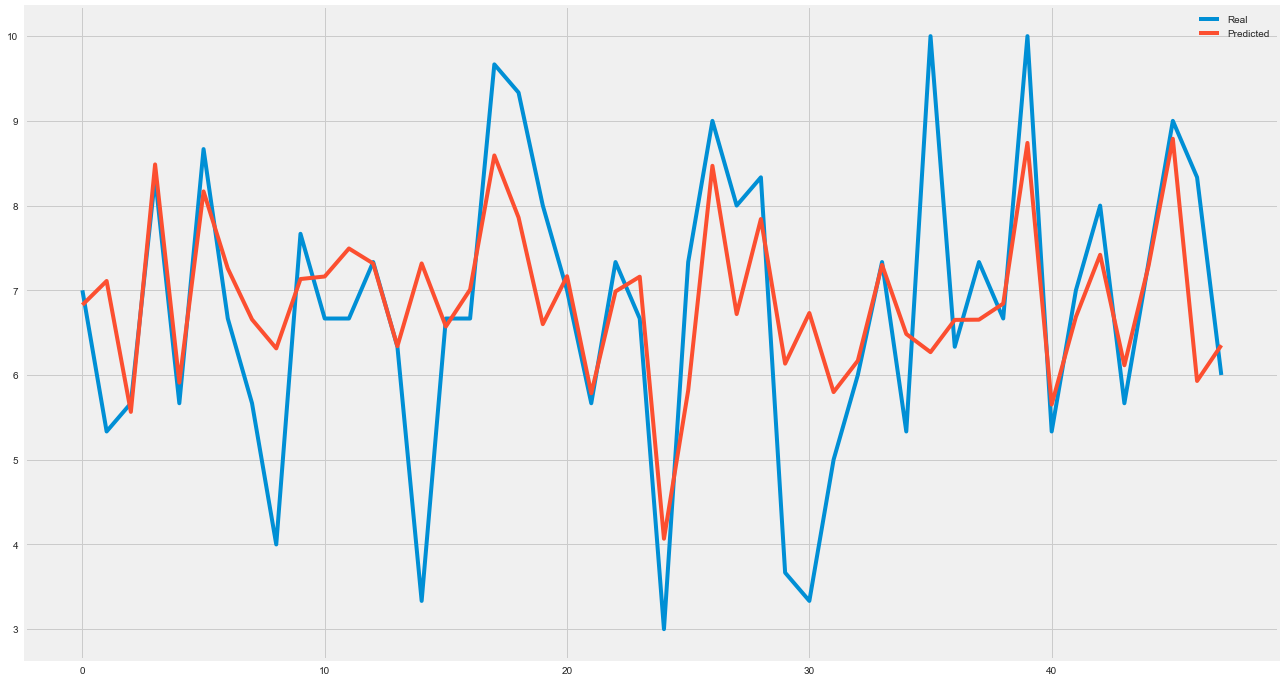

In [917]:
plt.figure(figsize=(20,12))

model = h2o.get_model('GBM_grid_0_AutoML_20181021_195831_model_5')

# See how a P model performed

df_test = df.sample(frac=0.3)

h2o_validate = h2o.H2OFrame(df_test.drop(target_features, axis=1))

pred = model.predict(h2o_validate)

plt.plot(range(0,len(df_test)), df_test.P, label='Real')
plt.plot(range(0,len(pred.as_data_frame())), pred.as_data_frame().predict, label='Predicted')

plt.legend()

In [918]:
df_importances = model._model_json['output']['variable_importances'].as_data_frame()

df_importances

,variable,relative_importance,scaled_importance,percentage
0,avg_posts_early_day,173.261002,1.000000,0.110961
1,avg_posts_late_night,146.567566,0.845935,0.093866
2,avg_posts_early_night,121.171532,0.699358,0.077601
3,age,96.036736,0.554289,0.061504
4,avg_posts_night,82.538582,0.476383,0.052860
5,ratio_male,82.180954,0.474319,0.052631
6,Sky,81.726662,0.471697,0.052340
7,avg_posts_whole_date,80.090141,0.462251,0.051292
8,depressed_flt_pct,78.754875,0.454545,0.050437
9,income,62.387711,0.360079,0.039955


In [919]:
low_importances = df_importances[df_importances.scaled_importance < 0.3]
df_reloaded = df_reloaded.drop(low_importances.variable, axis=1)

In [920]:
h2o.remove_all()

for feature in target_features[0]:
    
    print('### Runnning AutoML for Predicting {} ###'.format(feature))
    
    aux_target_features = target_features.copy()
    
    #Remove remaining features as they could leak info into our dataset
    
    aux_target_features.remove(feature)
    
    df_pred = df_reloaded.drop(aux_target_features, axis=1)
    
    ### Teste ###
    
    #df_pred = df_pred.iloc[:,:60]
    
    df_train = df_pred.sample(frac=0.8)
    
    h2o_train = h2o.H2OFrame(df_train)
    h2o_test = h2o.H2OFrame(df_pred[~np.isin(df_pred.index, df_train.index)])
    
    exclude_algos = ['DeepLearning', 'GLM', 'StackedEnsemble']
    
    automl.generate_predictions_automl(h2o_train, h2o_test, exclude_algos, 10, 123, 15, feature)

### Runnning AutoML for Predicting P ###


/anaconda/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
['age', 'user_follows', 'Person', 'Food', 'Sky', 'depressed_flt_pct', 'avg_posts_early_day', 'avg_posts_early_night', 'avg_posts_late_night', 'avg_posts_night', 'avg_posts_whole_date', 'SURPRISED', 'ratio_male', 'income', 'P', 'imagecount']
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid_0_AutoML_20181021_195936_model_6,2.60133,1.61286,2.60133,1.25607,0.237471
GBM_grid_0_AutoML_20181021_195936_model_0,2.64519,1.62641,2.64519,1.25687,0.238632
XRT_0_AutoML_20181021_195936,2.67122,1.63439,2.67122,1.28529,0.240537
DRF_0_AutoML_20181021_195936,2.69068,1.64033,2.69068,1.28247,0.241786
GBM_grid_0_AutoML_20181021_195936_model_3,2.73993,1.65527,2.73993,1.29275,0.241802
GBM_grid_0_AutoML_20181021_195936_model_2,2.73993,1.65527,2.73993,1.29275,0.241802
GBM_grid_0_AutoML_20181021_195936_model_1,2.73993,1.65527,2.73993,1.29275,0.241802
GBM_grid_0_AutoML_20181021_195936_model_5,2.74673,1.65732,2.74673,1.29087,0.243408
GBM_grid_0_AutoML_20181021_195936_model_4,2.8052,1.67487,2.8052,1.32535,0.242807



                 variable  relative_importance  scaled_importance  percentage
0              ratio_male            68.782333           1.000000    0.272677
1         avg_posts_night            53.423775           0.776708    0.211790
2               SURPRISED            39.077080           0.568127    0.154915
3       depressed_flt_pct            23.172224           0.336892    0.091863
4                     age            19.791920           0.287747    0.078462
5   avg_posts_early_night            19.228809           0.279560    0.076230
6                     Sky            10.209087           0.148426    0.040472
7              imagecount             9.404697           0.136731    0.037283
8     avg_posts_early_day             5.780085           0.084034    0.022914
9    avg_posts_late_night             3.378246           0.049115    0.013393
10           user_follows             0.000000           0.000000    0.000000
11                 Person             0.000000           0.0000

/anaconda/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


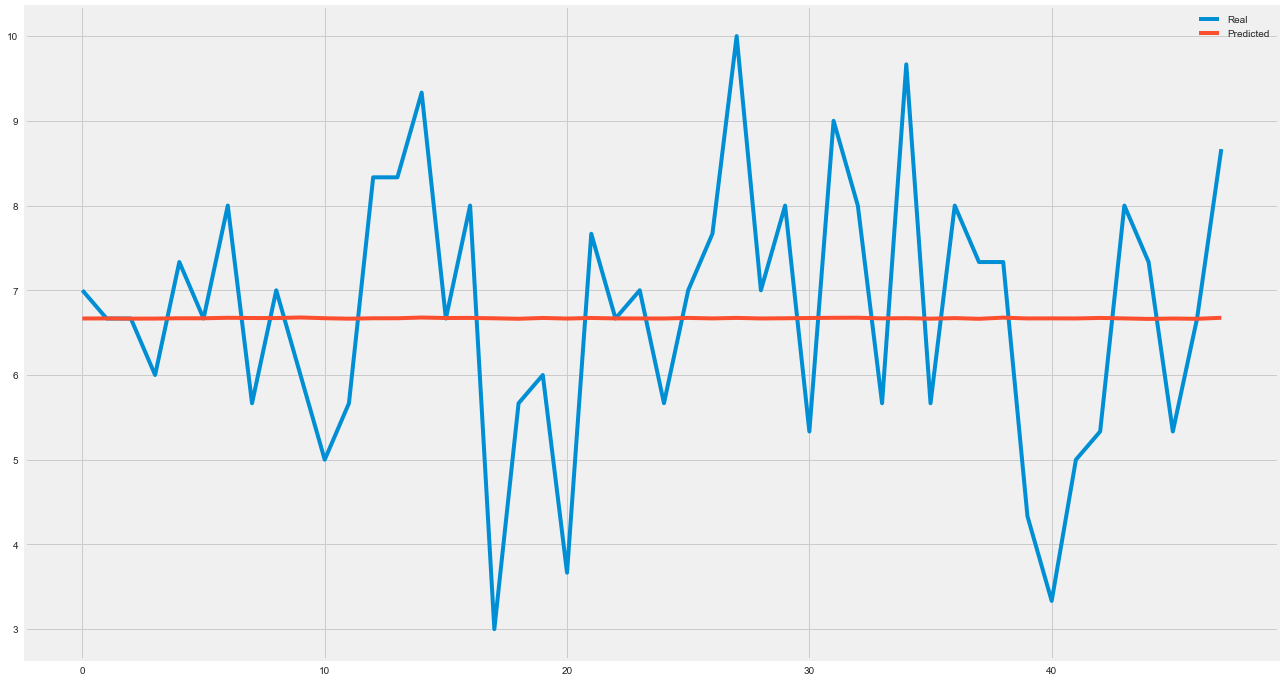

In [921]:
plt.figure(figsize=(20,12))

model = h2o.get_model('GBM_grid_0_AutoML_20181021_195936_model_6')

# See how a P model performed

df_test = df.sample(frac=0.3)

h2o_validate = h2o.H2OFrame(df_test.drop(target_features, axis=1))

pred = model.predict(h2o_validate)

plt.plot(range(0,len(df_test)), df_test.P, label='Real')
plt.plot(range(0,len(pred.as_data_frame())), pred.as_data_frame().predict, label='Predicted')

plt.legend()

In [922]:
df_importances = model._model_json['output']['variable_importances'].as_data_frame()

df_importances

,variable,relative_importance,scaled_importance,percentage
0,ratio_male,68.782333,1.000000,0.272677
1,avg_posts_night,53.423775,0.776708,0.211790
2,SURPRISED,39.077080,0.568127,0.154915
3,depressed_flt_pct,23.172224,0.336892,0.091863
4,age,19.791920,0.287747,0.078462
5,avg_posts_early_night,19.228809,0.279560,0.076230
6,Sky,10.209087,0.148426,0.040472
7,imagecount,9.404697,0.136731,0.037283
8,avg_posts_early_day,5.780085,0.084034,0.022914
9,avg_posts_late_night,3.378246,0.049115,0.013393


In [923]:
df_importances.scaled_importance.describe()

count    15.000000
mean      0.244489
std       0.310997
min       0.000000
25%       0.000000
50%       0.136731
75%       0.312320
max       1.000000
Name: scaled_importance, dtype: float64

In [906]:
low_importances = df_importances[df_importances.scaled_importance < 0.1]
df_reloaded = df_reloaded.drop(low_importances.variable, axis=1)

In [907]:
h2o.remove_all()

for feature in target_features[0]:
    
    print('### Runnning AutoML for Predicting {} ###'.format(feature))
    
    aux_target_features = target_features.copy()
    
    #Remove remaining features as they could leak info into our dataset
    
    aux_target_features.remove(feature)
    
    df_pred = df_reloaded.drop(aux_target_features, axis=1)
    
    ### Teste ###
    
    #df_pred = df_pred.iloc[:,:60]
    
    df_train = df_pred.sample(frac=0.8)
    
    h2o_train = h2o.H2OFrame(df_train)
    h2o_test = h2o.H2OFrame(df_pred[~np.isin(df_pred.index, df_train.index)])
    
    exclude_algos = ['DeepLearning', 'StackedEnsemble', 'GLM']
    
    automl.generate_predictions_automl(h2o_train, h2o_test, exclude_algos, 5, 123, 15, feature)

### Runnning AutoML for Predicting P ###


/anaconda/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
['Food', 'avg_number_of_faces_over_images_with_faces', 'depressed_flt_pct', 'avg_posts_early_day', 'avg_posts_early_night', 'avg_posts_late_night', 'avg_posts_whole_date', 'SURPRISED', 'ratio_female', 'born', 'P', 'imagecount']
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid_0_AutoML_20181021_195600_model_7,3.47083,1.86302,3.47083,1.51072,0.280261
GBM_grid_0_AutoML_20181021_195600_model_8,3.48367,1.86646,3.48367,1.51272,0.281088
GBM_grid_0_AutoML_20181021_195600_model_6,3.49114,1.86846,3.49114,1.51427,0.281407
GBM_grid_0_AutoML_20181021_195600_model_4,3.74641,1.93557,3.74641,1.52685,0.286958
GBM_grid_0_AutoML_20181021_195600_model_5,3.80927,1.95173,3.80927,1.56493,0.289516
GBM_grid_0_AutoML_20181021_195600_model_1,3.87732,1.96909,3.87732,1.59821,0.289016
GBM_grid_0_AutoML_20181021_195600_model_3,3.87732,1.96909,3.87732,1.59821,0.289016
GBM_grid_0_AutoML_20181021_195600_model_2,3.87732,1.96909,3.87732,1.59821,0.289016
DRF_0_AutoML_20181021_195600,4.18146,2.04486,4.18146,1.66099,0.302074
GBM_grid_0_AutoML_20181021_195600_model_0,4.39281,2.0959,4.39281,1.66004,0.308742



                                      variable  relative_importance  \
0                        avg_posts_early_night           836.507141   
1                         avg_posts_late_night           548.976562   
2                                         born           544.631714   
3                                    SURPRISED           510.833618   
4                                   imagecount           506.883331   
5                         avg_posts_whole_date           487.391754   
6                                 ratio_female           473.585693   
7                                         Food           442.866913   
8                          avg_posts_early_day           441.586395   
9   avg_number_of_faces_over_images_with_faces           433.061890   
10                           depressed_flt_pct           218.981583   

    scaled_importance  percentage  
0            1.000000    0.153620  
1            0.656272    0.100816  
2            0.651078    0.100019  
3 

/anaconda/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


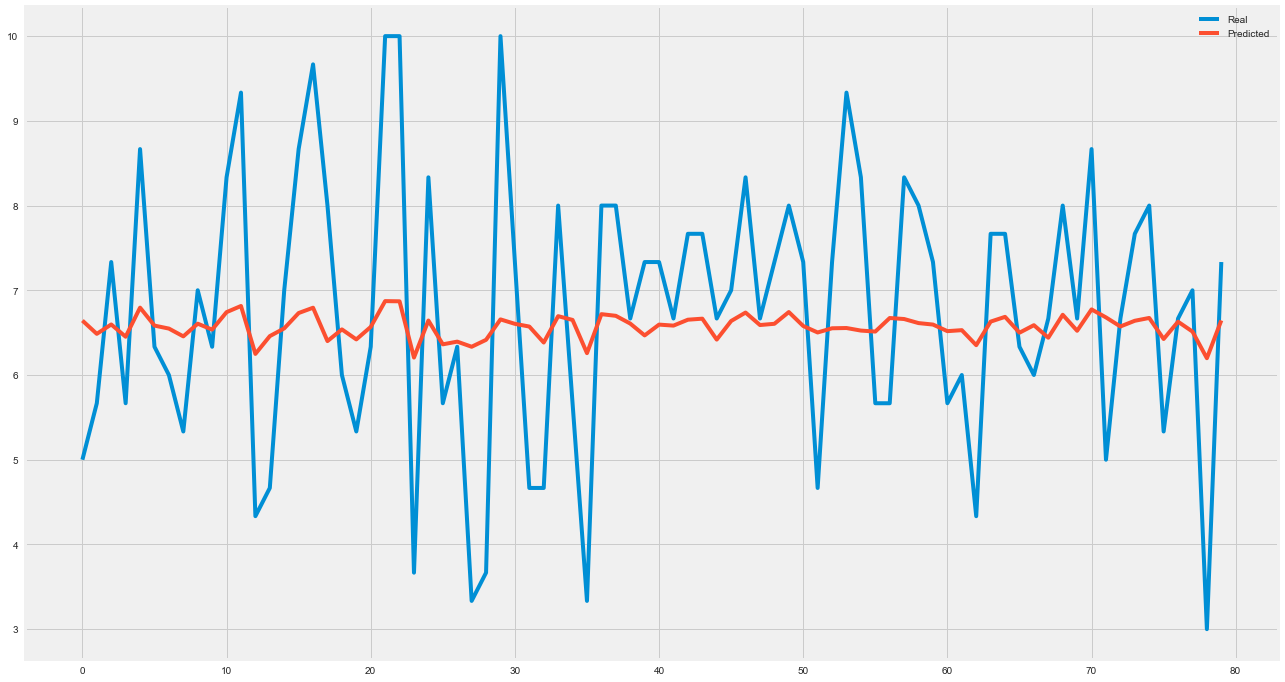

In [908]:
plt.figure(figsize=(20,12))

model = h2o.get_model('GBM_grid_0_AutoML_20181021_195600_model_7')

# See how a P model performed

df_test = df.sample(frac=0.5)

h2o_validate = h2o.H2OFrame(df_test.drop(target_features, axis=1))

pred = model.predict(h2o_validate)

plt.plot(range(0,len(df_test)), df_test.P, label='Real')
plt.plot(range(0,len(pred.as_data_frame())), pred.as_data_frame().predict, label='Predicted')

plt.legend()

In [757]:
df_importances = model._model_json['output']['variable_importances'].as_data_frame()

df_importances

,variable,relative_importance,scaled_importance,percentage
0,ratio_male,84.334297,1.000000,0.241904
1,avg_posts_night,82.215057,0.974871,0.235825
2,employed,37.323498,0.442566,0.107058
3,depressed_flt_pct,30.396864,0.360433,0.087190
4,avg_likes,29.616375,0.351178,0.084951
5,income,29.311638,0.347565,0.084077
6,happy_flt_pct,27.194424,0.322460,0.078004
7,avg_posts_whole_date,21.314631,0.252740,0.061139
8,avg_posts_early_day,3.827149,0.045381,0.010978
9,Person,3.093469,0.036681,0.008873


In [758]:
low_importances = df_importances[df_importances.scaled_importance < 0.25]
df_reloaded = df_reloaded.drop(low_importances.variable, axis=1)

In [759]:
h2o.remove_all()

for feature in target_features[0]:
    
    print('### Runnning AutoML for Predicting {} ###'.format(feature))
    
    aux_target_features = target_features.copy()
    
    #Remove remaining features as they could leak info into our dataset
    
    aux_target_features.remove(feature)
    
    df_pred = df_reloaded.drop(aux_target_features, axis=1)
    
    ### Teste ###
    
    #df_pred = df_pred.iloc[:,:60]
    
    df_train = df_pred.sample(frac=0.8)
    
    h2o_train = h2o.H2OFrame(df_train)
    h2o_test = h2o.H2OFrame(df_pred[~np.isin(df_pred.index, df_train.index)])
    
    exclude_algos = ['DeepLearning', 'StackedEnsemble', 'GLM']
    
    automl.generate_predictions_automl(h2o_train, h2o_test, exclude_algos, 2, 123, 15, feature)

### Runnning AutoML for Predicting P ###


/anaconda/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
['avg_likes', 'happy_flt_pct', 'depressed_flt_pct', 'avg_posts_night', 'avg_posts_whole_date', 'ratio_male', 'employed', 'income', 'completed', 'P', 'private_account']
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
XRT_0_AutoML_20181021_183206,2.28336,1.51108,2.28336,1.22353,0.207637
GBM_grid_0_AutoML_20181021_183206_model_7,2.38324,1.54378,2.38324,1.25106,0.215138
GBM_grid_0_AutoML_20181021_183206_model_8,2.41339,1.55351,2.41339,1.25145,0.21666
GBM_grid_0_AutoML_20181021_183206_model_5,2.45305,1.56622,2.45305,1.30474,0.215686
DRF_0_AutoML_20181021_183206,2.55435,1.59823,2.55435,1.31805,0.219701
GBM_grid_0_AutoML_20181021_183206_model_3,2.61524,1.61717,2.61524,1.31752,0.222328
GBM_grid_0_AutoML_20181021_183206_model_2,2.61524,1.61717,2.61524,1.31752,0.222328
GBM_grid_0_AutoML_20181021_183206_model_1,2.61524,1.61717,2.61524,1.31752,0.222328
GBM_grid_0_AutoML_20181021_183206_model_10,2.90165,1.70342,2.90165,1.35716,0.233679
GBM_grid_0_AutoML_20181021_183206_model_11,2.98875,1.7288,2.98875,1.37384,0.237815



               variable  relative_importance  scaled_importance  percentage
0                income           267.066254           1.000000    0.187800
1       avg_posts_night           240.484314           0.900467    0.169108
2            ratio_male           229.231598           0.858332    0.161195
3  avg_posts_whole_date           187.607529           0.702476    0.131925
4              employed           152.253372           0.570096    0.107064
5         happy_flt_pct           122.758057           0.459654    0.086323
6     depressed_flt_pct           111.369530           0.417011    0.078315
7             avg_likes           111.308662           0.416783    0.078272


/anaconda/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


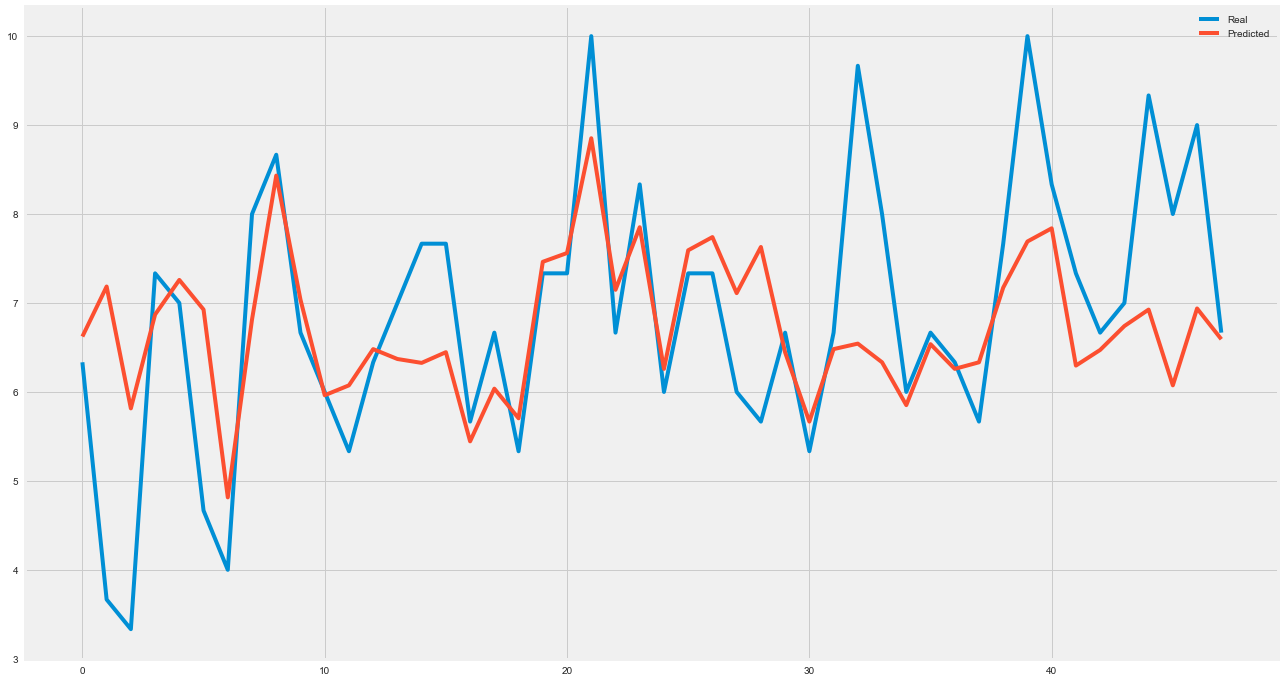

In [761]:
plt.figure(figsize=(20,12))

model = h2o.get_model('XRT_0_AutoML_20181021_183206')

# See how a P model performed

df_test = df.sample(frac=0.3)

h2o_validate = h2o.H2OFrame(df_test.drop(target_features, axis=1))

pred = model.predict(h2o_validate)

plt.plot(range(0,len(df_test)), df_test.P, label='Real')
plt.plot(range(0,len(pred.as_data_frame())), pred.as_data_frame().predict, label='Predicted')

plt.legend()

In [762]:
df_importances = model._model_json['output']['variable_importances'].as_data_frame()

df_importances

,variable,relative_importance,scaled_importance,percentage
0,income,267.066254,1.000000,0.187800
1,avg_posts_night,240.484314,0.900467,0.169108
2,ratio_male,229.231598,0.858332,0.161195
3,avg_posts_whole_date,187.607529,0.702476,0.131925
4,employed,152.253372,0.570096,0.107064
5,happy_flt_pct,122.758057,0.459654,0.086323
6,depressed_flt_pct,111.369530,0.417011,0.078315
7,avg_likes,111.308662,0.416783,0.078272


In [763]:
low_importances = df_importances[df_importances.scaled_importance < 0.5]
df_reloaded = df_reloaded.drop(low_importances.variable, axis=1)

In [764]:
h2o.remove_all()

for feature in target_features[0]:
    
    print('### Runnning AutoML for Predicting {} ###'.format(feature))
    
    aux_target_features = target_features.copy()
    
    #Remove remaining features as they could leak info into our dataset
    
    aux_target_features.remove(feature)
    
    df_pred = df_reloaded.drop(aux_target_features, axis=1)
    
    ### Teste ###
    
    #df_pred = df_pred.iloc[:,:60]
    
    df_train = df_pred.sample(frac=0.8)
    
    h2o_train = h2o.H2OFrame(df_train)
    h2o_test = h2o.H2OFrame(df_pred[~np.isin(df_pred.index, df_train.index)])
    
    exclude_algos = ['DeepLearning', 'StackedEnsemble', 'GLM']
    
    automl.generate_predictions_automl(h2o_train, h2o_test, exclude_algos, 2, 123, 15, feature)

### Runnning AutoML for Predicting P ###


/anaconda/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
['avg_posts_night', 'avg_posts_whole_date', 'ratio_male', 'employed', 'income', 'completed', 'P', 'private_account']
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
DRF_0_AutoML_20181021_183254,2.42778,1.55813,2.42778,1.25783,0.218859
GBM_grid_0_AutoML_20181021_183254_model_7,2.44244,1.56283,2.44244,1.25303,0.222229
GBM_grid_0_AutoML_20181021_183254_model_8,2.49715,1.58024,2.49715,1.27069,0.224661
XRT_0_AutoML_20181021_183254,2.57983,1.60618,2.57983,1.30582,0.225429
GBM_grid_0_AutoML_20181021_183254_model_3,2.80597,1.6751,2.80597,1.35133,0.235837
GBM_grid_0_AutoML_20181021_183254_model_2,2.80597,1.6751,2.80597,1.35133,0.235837
GBM_grid_0_AutoML_20181021_183254_model_1,2.80597,1.6751,2.80597,1.35133,0.235837
GBM_grid_0_AutoML_20181021_183254_model_5,2.81583,1.67804,2.81583,1.31541,0.237855
GBM_grid_0_AutoML_20181021_183254_model_0,3.16036,1.77774,3.16036,1.44171,0.253076
GBM_grid_0_AutoML_20181021_183254_model_10,3.63368,1.90622,3.63368,1.53948,0.267512



               variable  relative_importance  scaled_importance  percentage
0       avg_posts_night           393.040253           1.000000    0.259969
1            ratio_male           334.270721           0.850475    0.221097
2                income           294.726440           0.749863    0.194941
3  avg_posts_whole_date           246.148758           0.626269    0.162810
4              employed           243.687714           0.620007    0.161183


/anaconda/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


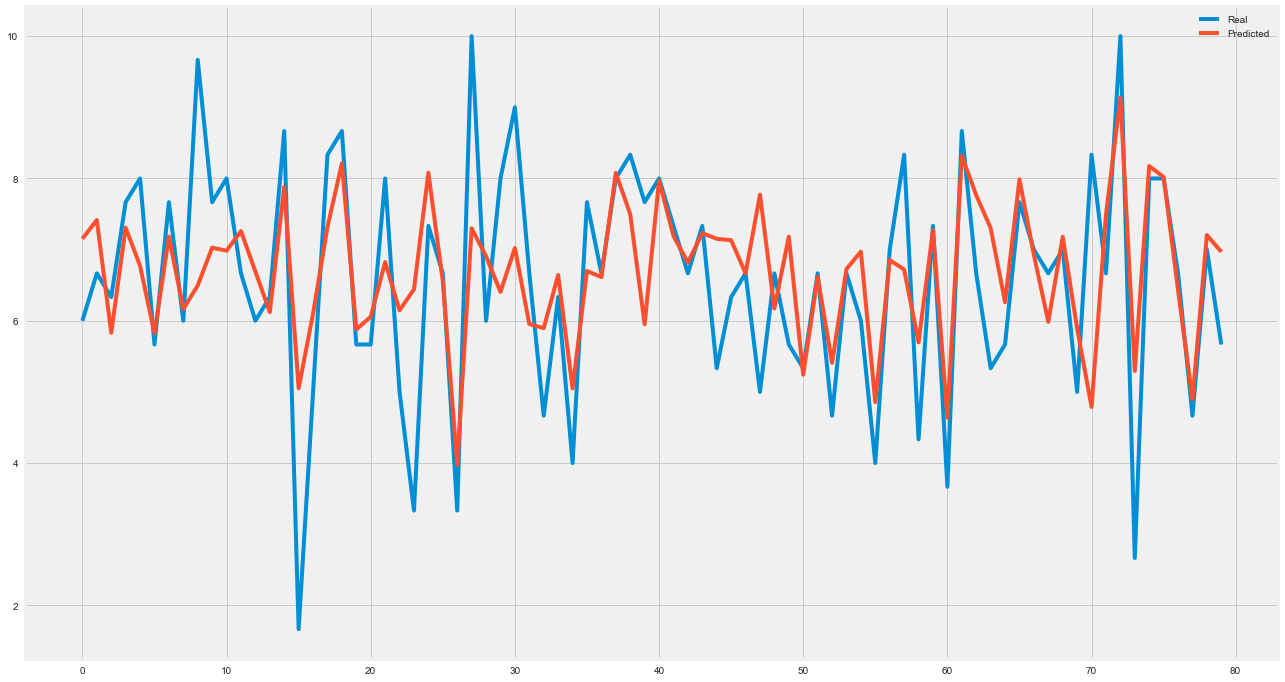

In [765]:
plt.figure(figsize=(20,12))

model = h2o.get_model('DRF_0_AutoML_20181021_183254')

# See how a P model performed

df_test = df.sample(frac=0.5)

h2o_validate = h2o.H2OFrame(df_test.drop(target_features, axis=1))

pred = model.predict(h2o_validate)

plt.plot(range(0,len(df_test)), df_test.P, label='Real')
plt.plot(range(0,len(pred.as_data_frame())), pred.as_data_frame().predict, label='Predicted')

plt.legend()

In [766]:
df_importances = model._model_json['output']['variable_importances'].as_data_frame()

df_importances

,variable,relative_importance,scaled_importance,percentage
0,avg_posts_night,393.040253,1.000000,0.259969
1,ratio_male,334.270721,0.850475,0.221097
2,income,294.726440,0.749863,0.194941
3,avg_posts_whole_date,246.148758,0.626269,0.162810
4,employed,243.687714,0.620007,0.161183


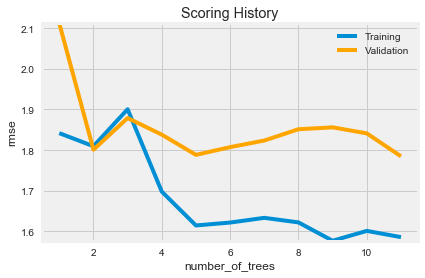

In [769]:
model.plot()

In [387]:
h2o.remove_all()

for feature in target_features[0]:
    
    print('### Runnning AutoML for Predicting {} ###'.format(feature))
    
    aux_target_features = target_features.copy()
    
    #Remove remaining features as they could leak info into our dataset
    
    aux_target_features.remove(feature)
    
    df_pred = df_reloaded.drop(aux_target_features, axis=1)
    
    ### Teste ###
    
    #df_pred = df_pred.iloc[:,:60]
    
    df_train = df_pred.sample(frac=0.8)
    
    h2o_train = h2o.H2OFrame(df_train)
    h2o_test = h2o.H2OFrame(df_pred[~np.isin(df_pred.index, df_train.index)])
    
    exclude_algos = ['DeepLearning', 'StackedEnsemble', 'GLM']
    
    automl.generate_predictions_automl(h2o_train, h2o_test, exclude_algos, 2, 123, 15, feature)

### Runnning AutoML for Predicting P ###


/anaconda/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
['avg_posts_early_day', 'avg_posts_early_night', 'ratio_male', 'income', 'completed', 'network_id', 'P', 'private_account']
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid_0_AutoML_20181021_165142_model_7,2.94519,1.71616,2.94519,1.36993,0.256104
GBM_grid_0_AutoML_20181021_165142_model_8,2.95172,1.71806,2.95172,1.36758,0.256302
GBM_grid_0_AutoML_20181021_165142_model_9,3.0135,1.73594,3.0135,1.41837,0.256516
GBM_grid_0_AutoML_20181021_165142_model_5,3.14513,1.77345,3.14513,1.44278,0.263875
GBM_grid_0_AutoML_20181021_165142_model_11,3.15623,1.77658,3.15623,1.43957,0.260271
GBM_grid_0_AutoML_20181021_165142_model_1,3.19685,1.78797,3.19685,1.44826,0.264443
GBM_grid_0_AutoML_20181021_165142_model_3,3.19685,1.78797,3.19685,1.44826,0.264443
GBM_grid_0_AutoML_20181021_165142_model_2,3.19685,1.78797,3.19685,1.44826,0.264443
GBM_grid_0_AutoML_20181021_165142_model_10,3.44856,1.85703,3.44856,1.55049,0.271973
DRF_0_AutoML_20181021_165142,3.51581,1.87505,3.51581,1.53108,0.277573



                variable  relative_importance  scaled_importance  percentage
0  avg_posts_early_night          1274.110962           1.000000    0.274935
1             ratio_male          1236.278931           0.970307    0.266771
2    avg_posts_early_day          1169.586182           0.917963    0.252380
3                 income           954.250427           0.748954    0.205914


/anaconda/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


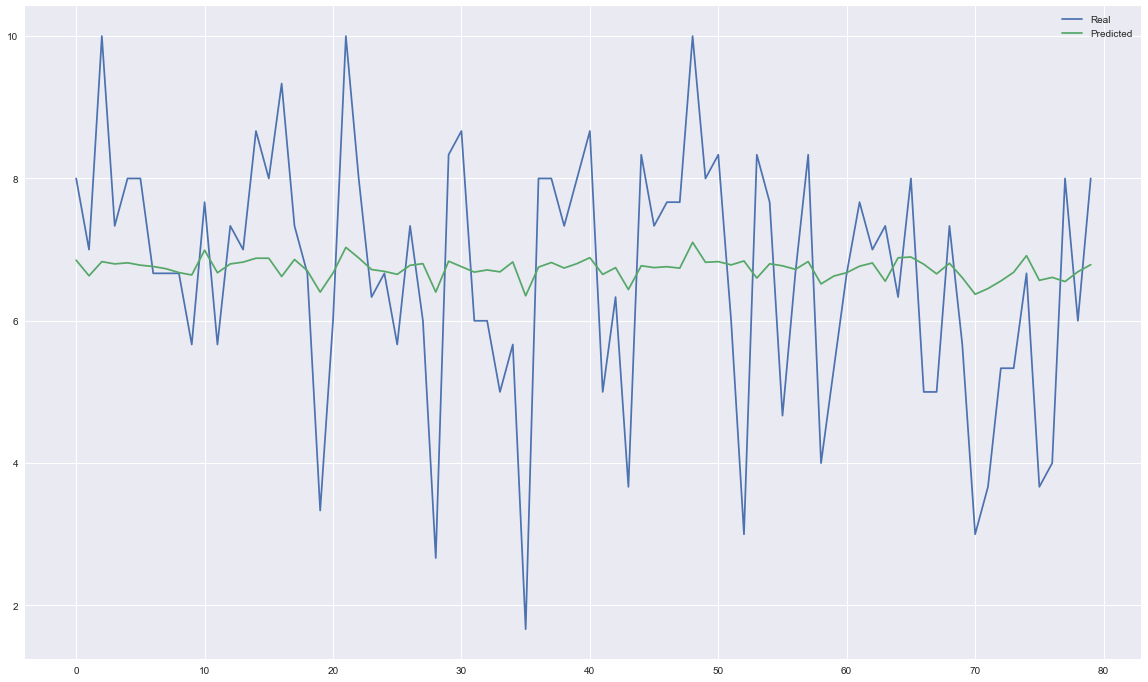

In [388]:
plt.figure(figsize=(20,12))

model = h2o.get_model('GBM_grid_0_AutoML_20181021_165142_model_7')

# See how a P model performed

df_test = df.sample(frac=0.5)

h2o_validate = h2o.H2OFrame(df_test.drop(target_features, axis=1))

pred = model.predict(h2o_validate)

plt.plot(range(0,len(df_test)), df_test.P, label='Real')
plt.plot(range(0,len(pred.as_data_frame())), pred.as_data_frame().predict, label='Predicted')

plt.legend()

In [389]:
df.describe()

,level_0,age,user_followed_by,user_follows,user_posted_photos,Person,Plant,Food,Collage,Animal,...,ratio_female,born,insta_user_id,P,E,R,M,A,PERMA,imagecount
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,...,159.000000,159.000000,1.590000e+02,159.000000,159.000000,159.000000,159.000000,159.000000,158.000000,159.000000
mean,79.000000,30.842767,389.106918,552.352201,278.371069,0.413538,0.038498,0.023865,0.016142,0.019576,...,0.231346,1985.490566,1.034358e+09,6.670860,7.094340,7.088050,6.911950,6.930818,6.935127,259.157233
std,46.043458,9.241167,627.111033,1130.472020,435.241073,0.279651,0.090086,0.054885,0.025396,0.036973,...,0.227330,9.332716,1.149397e+09,1.690125,1.447697,1.913184,1.846597,1.542677,1.427607,354.777779
min,0.000000,19.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1948.000000,1.619510e+06,1.666667,2.666667,1.000000,2.000000,2.333333,3.250000,1.000000
25%,39.500000,24.000000,70.000000,86.500000,22.000000,0.189652,0.000000,0.000000,0.000000,0.000000,...,0.055744,1981.000000,1.642428e+08,5.666667,6.333333,6.000000,6.000000,6.000000,6.078125,22.000000
50%,79.000000,29.000000,191.000000,210.000000,100.000000,0.387755,0.020833,0.007605,0.007463,0.004525,...,0.168817,1987.000000,4.214747e+08,6.666667,7.000000,7.000000,7.000000,7.000000,7.156250,98.000000
75%,118.500000,35.000000,391.500000,475.000000,374.000000,0.622543,0.045163,0.022604,0.022739,0.020352,...,0.358763,1992.000000,1.926901e+09,8.000000,8.333333,8.333333,8.166667,8.000000,7.750000,370.500000
max,158.000000,68.000000,4240.000000,7322.000000,2997.000000,1.000000,1.000000,0.500000,0.161905,0.269231,...,1.000000,1998.000000,4.249629e+09,10.000000,9.666667,10.000000,10.000000,10.000000,9.562500,1545.000000


In [390]:
df[df.user_followed_by == 0]

,level_0,age,user_followed_by,user_follows,user_posted_photos,Person,Plant,Food,Collage,Animal,...,end_q,network_id,P,E,R,M,A,PERMA,imagecount,private_account
147,147,29.0,0.0,7.0,1.0,1.0,0.0,0.0,0.0,0.0,...,2016-12-05 14:58:36,8a43e0f5d2,4.0,7.0,7.0,3.333333,7.0,5.5625,1.0,public


In [391]:
df[df.user_follows == 0]

,level_0,age,user_followed_by,user_follows,user_posted_photos,Person,Plant,Food,Collage,Animal,...,end_q,network_id,P,E,R,M,A,PERMA,imagecount,private_account
150,150,26.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2016-12-05 14:48:29,ea076ab820,5.0,5.666667,3.333333,3.666667,4.0,4.375,1.0,public
